In [7]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport

In [2]:
# load the dataset
df = pd.read_csv("StudentsPerformance.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
# general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [5]:
# handle nulls
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [6]:
# duplicates
df.duplicated().sum()

np.int64(0)


Pass/Fail counts:
pass
1    715
0    285
Name: count, dtype: int64


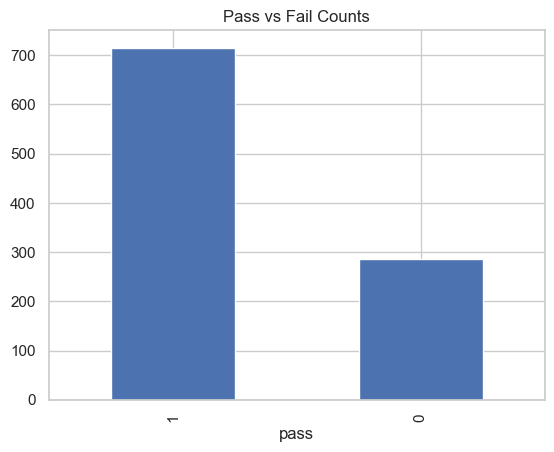

In [11]:
# create pass/fail column

# Calculate average score
df['average_score'] = (df['math score'] + df['reading score'] + df['writing score']) / 3

# Create pass/fail column (1 = pass, 0 = fail)
df['pass'] = df['average_score'].apply(lambda x: 1 if x >= 60 else 0)

# Check distribution
print("\nPass/Fail counts:")
print(df['pass'].value_counts())

# Visualize
df['pass'].value_counts().plot(kind='bar', title='Pass vs Fail Counts')
plt.show()

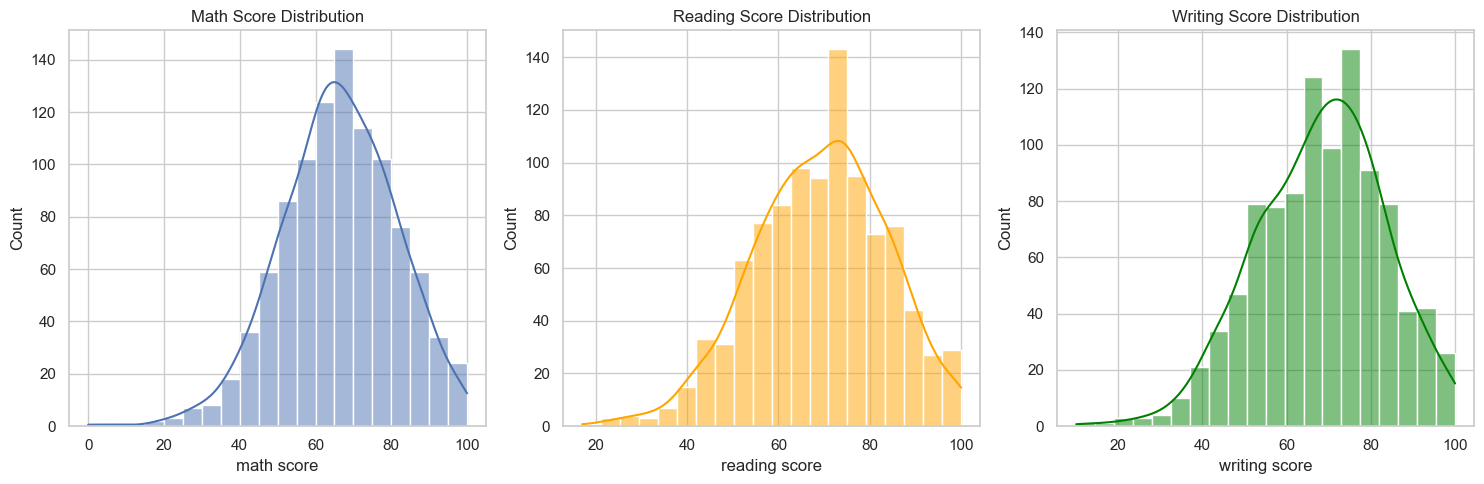

In [ ]:
# visualizations
# Create figure
plt.figure(figsize=(15, 5))

# Math scores
plt.subplot(1, 3, 1)
sns.histplot(df['math score'], bins=20, kde=True)
plt.title('Math Score Distribution')

# Reading scores
plt.subplot(1, 3, 2)
sns.histplot(df['reading score'], bins=20, kde=True, color='orange')
plt.title('Reading Score Distribution')

# Writing scores
plt.subplot(1, 3, 3)
sns.histplot(df['writing score'], bins=20, kde=True, color='green')
plt.title('Writing Score Distribution')

plt.tight_layout()
plt.show()

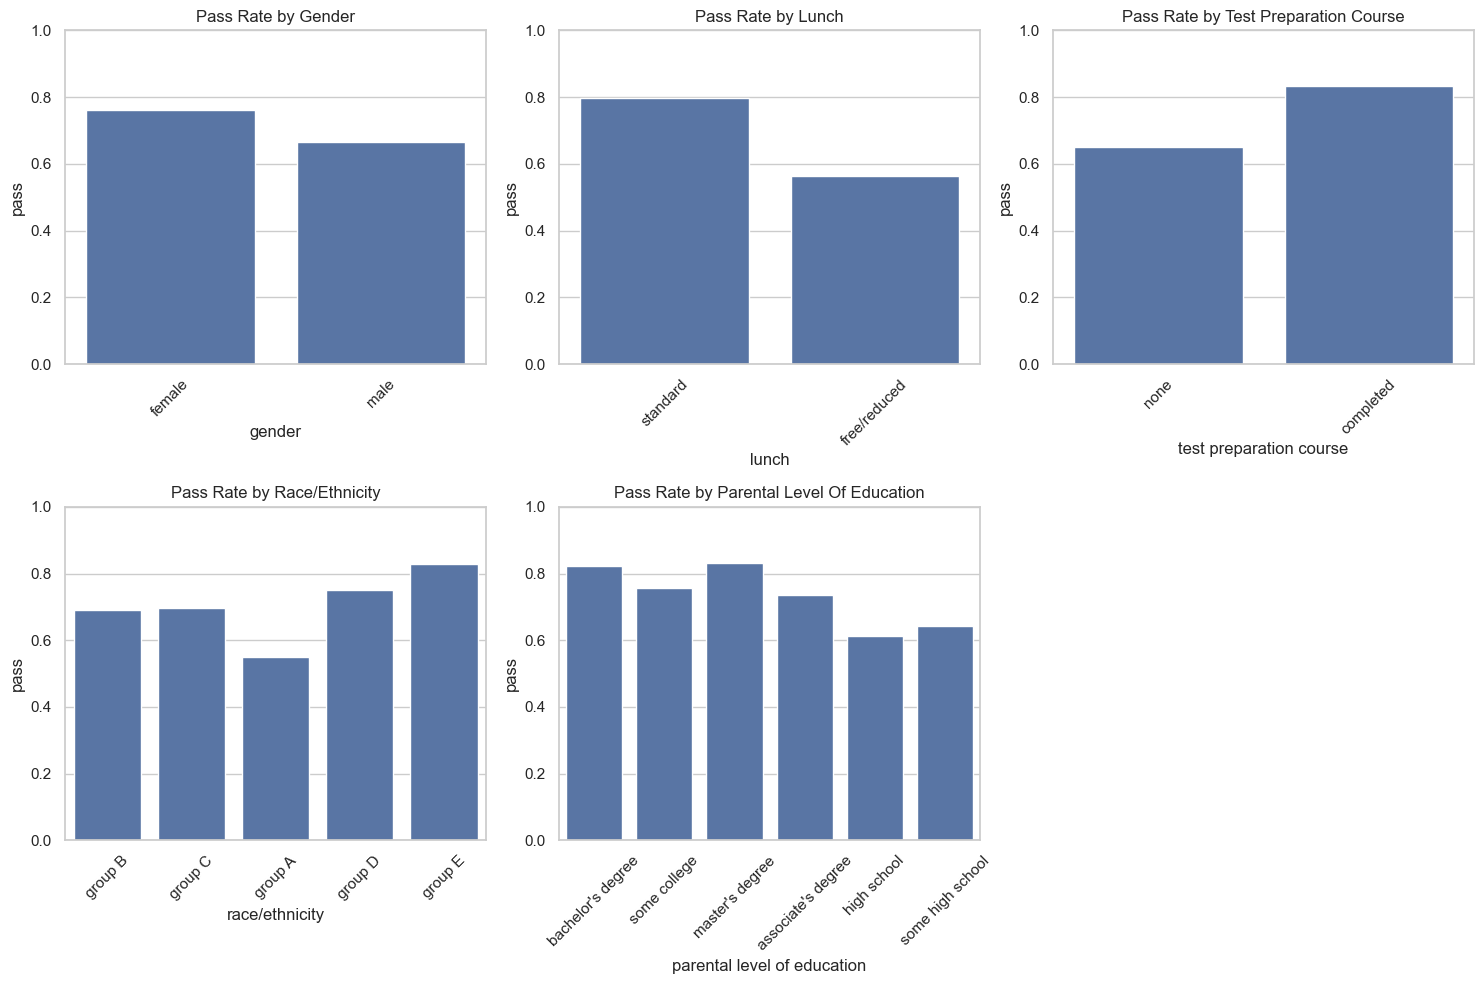

In [12]:
plt.figure(figsize=(15, 10))

features = ['gender', 'lunch', 'test preparation course', 
           'race/ethnicity', 'parental level of education']

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=df[feature], y=df['pass'], errorbar=None)
    plt.title(f'Pass Rate by {feature.title()}')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
plt.tight_layout()
plt.show()

## Encoding

In [13]:
from sklearn.preprocessing import OneHotEncoder

# Convert categorical data to numbers
df['gender'] = df['gender'].map({'female': 0, 'male': 1})
df['lunch'] = df['lunch'].map({'standard': 1, 'free/reduced': 0})
df['test preparation course'] = df['test preparation course'].map({'completed': 1, 'none': 0})

# One-hot encoding for remaining categories
df = pd.get_dummies(df, columns=['race/ethnicity', 'parental level of education'])

## Prepare Data for Modeling

In [14]:
# separate features and target variable
X = df.drop(['math score', 'reading score', 'writing score', 'average_score', 'pass'], axis=1)
y = df['pass']

In [16]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Train the Model

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluate the Model

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.685

In [23]:
# Show confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[ 16  46]
 [ 18 120]]


In [24]:
# Create example student data
new_student = {
    'gender': 0,  # female
    'lunch': 1,  # standard lunch
    'test preparation course': 1,  # completed prep course
    'race/ethnicity_group A': 0,
    'race/ethnicity_group B': 1,  # belongs to group B
    'race/ethnicity_group C': 0,
    'parental level of education_bachelor\'s degree': 1,
    'parental level of education_some college': 0
}

# Convert to DataFrame (fill missing columns with 0)
new_df = pd.DataFrame([new_student]).reindex(columns=X.columns, fill_value=0)

# Predict
prediction = model.predict(new_df)
print("\nPrediction:", "PASS" if prediction[0] == 1 else "FAIL")


Prediction: PASS


## Improve the Model 

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [29]:
# Predict on test set
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Best parameters
print("\nBest Parameters Found:")
print(grid_search.best_params_)


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.13      0.21        62
           1       0.71      0.94      0.81       138

    accuracy                           0.69       200
   macro avg       0.60      0.54      0.51       200
weighted avg       0.64      0.69      0.62       200


Best Parameters Found:
{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}


## Export the model for Streamlit

In [30]:
import joblib

# Save the best model
joblib.dump(best_model, 'student_pass_predictor.joblib')

['student_pass_predictor.joblib']